In [2]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [4]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'actors_xxxx_the_numbers')

In [5]:
#CONSTANTS
YEAR_OFFSET=2 # if 3: last triplet 2019, 2020, 2021;; if 2: last triplet 2020, 2021, 2022
START_INDEX=28 # 20 correspond to the triplet 2000, 2001, 2002
START_YEAR=1980+START_INDEX

In [6]:
#read the tsv files having the actor's popularity
tab_years=np.arange(1980,2022+1)
actors_rating=[]
for i, year in enumerate (tab_years):
    path_numbers = os.path.join(THE_NUMBERS_PATH, 'actors_{}_the_numbers.tsv'.format(year))
    actors_rating.append(pd.read_csv(path_numbers,
                              sep='\t',
                              escapechar=',',
                              names=['actor_name','popularity', 'movies', 'avg_billing']))

# 2. Creation of a pipeline

#### Check for duplicated actor name for each year

In [7]:
#check for duplicated actor name for each year
total_duplicated=0
for i in range (len(tab_years)):
    total_duplicated+=actors_rating[i].duplicated(subset='actor_name').sum()
print('There are {} actors that appear twice in the same year.'.format(total_duplicated))

There are 0 actors that appear twice in the same year.


#### Formatting the dataset in a useful way

In [8]:
number_actors_per_year=[]
df_ratings_all_years=actors_rating[0].set_index('actor_name')[['popularity']]
df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], '{}'.format(1980)], axis=1, inplace=True)
for i in range (len(tab_years)-1):
    number_actors_per_year.append((len(actors_rating[i+1])))
    df_ratings_all_years=pd.concat([df_ratings_all_years, actors_rating[i+1].set_index('actor_name')[['popularity']]],  axis=1)
    df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], '{}'.format(i+1+1980)], axis=1, inplace=True)
df_ratings_all_yearsT=df_ratings_all_years.T

ACTORS=list(df_ratings_all_yearsT)#all the actors present in the numbers dataset

print('There is a total of {} actors in the Number dataset.'.format(len(ACTORS)))

There is a total of 2702 actors in the Number dataset.


#### Mean of the score per actor

In [9]:
df_ratings_all_years['mean_score'] = df_ratings_all_years.mean(axis=1)
print("Actors with the highest mean popularity score computed on the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='mean_score', ascending=False).head()

Actors with the highest mean popularity score computed on the 42 years of the dataset.


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jennifer Lawrence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,561.0,518.0,489.0,298.0,195.0,97.0,97.0,57.0,NaN,283.636364
Chris Hemsworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,330.0,198.0,216.0,309.0,342.0,394.0,301.0,165.0,95.0,265.666667
Chris Pratt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98.0,197.0,337.0,335.0,432.0,392.0,296.0,100.0,98.0,253.888889
Kevin Hart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,248.0,304.0,437.0,368.0,307.0,324.0,227.0,165.0,NaN,252.900000
John Candy,NaN,NaN,NaN,NaN,NaN,205.0,253.0,405.0,276.0,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.666667


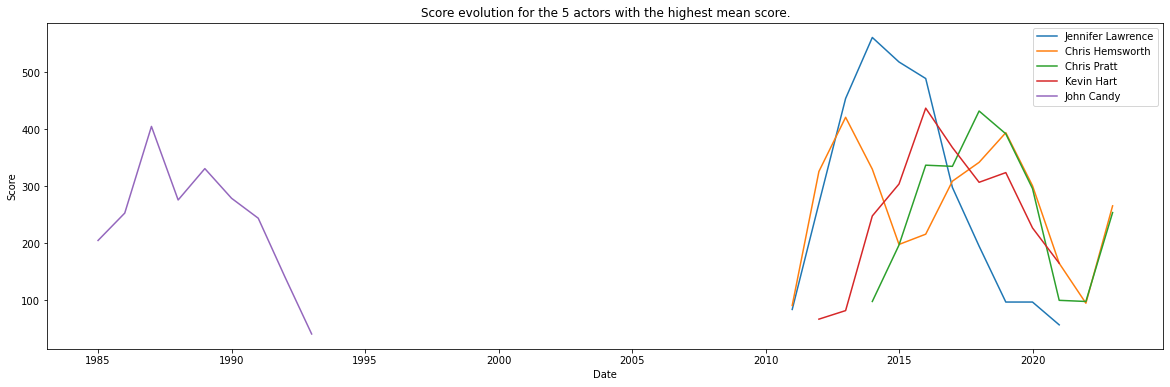

In [10]:
df_ratings_all_years.sort_values(by='mean_score', ascending=False).head().rename_axis(None).T.plot(figsize=(20,6))
plt.title("Score evolution for the 5 actors with the highest mean score.")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

#### Looking at the actor with most scores

In [11]:
df_ratings_all_years['is_na']=df_ratings_all_years.apply(lambda row: row.isna().sum().sum(), axis=1)
print("Actors that have the least \"empty years\" throughout the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3)

Actors that have the least "empty years" throughout the 42 years of the dataset.


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Harrison Ford,158.0,258.0,279.0,279.0,277.0,290.0,234.0,136.0,179.0,234.0,...,130.0,22.0,67.0,67.0,67.0,95.0,95.0,95.0,158.837209,0
Robert De Niro,169.0,115.0,115.0,39.0,28.0,28.0,80.0,92.0,165.0,130.0,...,185.0,129.0,129.0,20.0,NaN,86.0,86.0,141.0,147.238095,1
Meryl Streep,162.0,229.0,141.0,223.0,184.0,206.0,188.0,160.0,64.0,35.0,...,141.0,125.0,80.0,227.0,220.0,158.0,NaN,NaN,127.800000,3


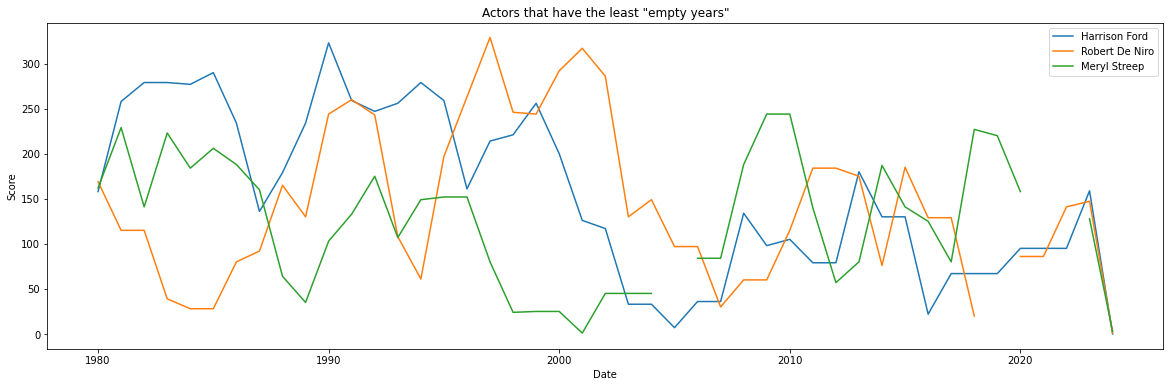

In [12]:
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3).rename_axis(None).T.plot(figsize=(20,6))
plt.title("Actors that have the least \"empty years\"")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

In [22]:
df_ratings_all_years

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,440.0,364.0,198.0,99.0,NaN,NaN,63.0,63.0,63.0,NaN,...,16.0,16.0,NaN,59.0,59.0,59.0,NaN,NaN,109.312500,27
Clint Eastwood,360.0,263.0,260.0,180.0,347.0,343.0,332.0,165.0,155.0,100.0,...,NaN,NaN,NaN,71.0,71.0,71.0,36.0,36.0,132.052632,5
John Belushi,269.0,295.0,217.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.500000,39
Burt Reynolds,262.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.500000,35
Goldie Hawn,258.0,170.0,251.0,81.0,147.0,66.0,132.0,125.0,125.0,59.0,...,NaN,NaN,43.0,43.0,43.0,NaN,NaN,NaN,104.814815,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Myha’la Herrold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,48.000000,42
Chase Sui Wonders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,48.000000,42
Rachel Sennott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,48.000000,42


# Output clean CSV

In [24]:
OUTPUT_FILE_NUMBERS = 'the_numbers_cleaned.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE_NUMBERS)
df_ratings_all_years.to_csv(OUTPUT_PATH, sep="\t")